# Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchsummary import summary
from functools import reduce
import matplotlib.pyplot as plt
import numpy as np
import random

# Hyperparameters

In [2]:
T = 10  # Diffusion steps
embed_dim = 10  # Label embedding dimension, since we use one-hot encoding, d = num of classes 
batch_size = 128
lr = 0.001
epochs = 10

In [3]:
# Noise schedule (linear)
alpha = torch.linspace(0.9, 0.2, T+1)  # α_t from 0.9 → 0.2
alpha_bar = torch.cumprod(alpha.flip(0), dim=0).flip(0)

print("Alpha:", alpha)
print("Alpha_bar:", alpha_bar)

SNR = alpha_bar / (1 - alpha_bar)  # Signal-to-noise ratio

# For computing a_t, b_t, c_t we need α_{t-1} and also the previous alpha bar 
alpha_bar_prev = torch.cat([torch.tensor([torch.nan]), alpha_bar[:-1]])
alpha_prev = torch.cat([torch.tensor([torch.nan]), alpha[:-1]])

a = torch.sqrt(alpha_bar) * (1 - alpha_prev) / (1 - alpha_bar_prev)
b = torch.sqrt(alpha_bar_prev) * (1 - alpha_bar) / (1 - alpha_bar_prev)
c = (1 - alpha_bar) * (1 - alpha_prev) / (1 - alpha_bar_prev)

print("SNR:", SNR)
print("a_t:", a)
print("b_t:", b) 
print("c_t:", c)

Alpha: tensor([0.9000, 0.8300, 0.7600, 0.6900, 0.6200, 0.5500, 0.4800, 0.4100, 0.3400,
        0.2700, 0.2000])
Alpha_bar: tensor([0.0005, 0.0005, 0.0006, 0.0009, 0.0012, 0.0020, 0.0036, 0.0075, 0.0184,
        0.0540, 0.2000])
SNR: tensor([0.0005, 0.0005, 0.0006, 0.0009, 0.0012, 0.0020, 0.0036, 0.0076, 0.0187,
        0.0571, 0.2500])
a_t: tensor([   nan, 0.0023, 0.0043, 0.0070, 0.0109, 0.0170, 0.0271, 0.0453, 0.0806,
        0.1562, 0.3451])
b_t: tensor([   nan, 0.0220, 0.0232, 0.0254, 0.0291, 0.0351, 0.0445, 0.0599, 0.0858,
        0.1306, 0.1965])
c_t: tensor([   nan, 0.1000, 0.1700, 0.2400, 0.3099, 0.3797, 0.4493, 0.5180, 0.5836,
        0.6360, 0.6173])


# Setting Up Models

In [4]:
# MLP for denoising
class BlockNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.final_dim_img = 32

        self.cnn =  nn.Sequential(  # process image x
            nn.Conv2d(1, 16, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(4),
            nn.Conv2d(16, 32, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(128, self.final_dim_img)
        )

        self.mlp1 = nn.Sequential(  # process previous layer activation z_{t-1}
            nn.Linear(embed_dim, 64),  
            nn.ReLU(),
            nn.Linear(64, embed_dim)     
        )

        self.mlp2 = nn.Sequential(  # process the concatenation of the previous two NN
            nn.Linear(self.final_dim_img + embed_dim, 256),  # Input: image features + noisy label features
            nn.ReLU(),
            nn.Linear(256, embed_dim)        # Output: approximate de-noised label u^ 
        )

    def forward(self, x, z_t):
        img_features = self.cnn(x)
        processed_activation = self.mlp1(z_t)

        combined = torch.cat([img_features, processed_activation], dim=1)  # returns u^ at block t+1
        return self.mlp2(combined)  # Fixed: was self.mlp, should be self.mlp2
    

# Initialize models
blockNN = nn.ModuleList([None] + [BlockNN() for _ in range(T)])  # Index 0 is None, blocks 1 to T
optimizers = [optim.Adam(blockNN[i].parameters(), lr=lr) for i in range(1, T+1)]  # Only create optimizers for actual blocks

In [5]:
print("=== DenoisingMLP Structure ===")
_b = blockNN[1] 

print("\nCNN Component Summary:")
print("Input: (1, 28, 28) - MNIST grayscale image")
summary(_b.cnn, (1, 28, 28), batch_size=batch_size)

print(f"\nMLP Component Summary:")
print(f"Input: ({128 + embed_dim},) - CNN features + noisy label")
summary(_b.mlp2, (32 + embed_dim,), batch_size=batch_size)

=== DenoisingMLP Structure ===

CNN Component Summary:
Input: (1, 28, 28) - MNIST grayscale image
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [128, 16, 26, 26]             160
              ReLU-2          [128, 16, 26, 26]               0
         MaxPool2d-3            [128, 16, 6, 6]               0
            Conv2d-4            [128, 32, 4, 4]           4,640
              ReLU-5            [128, 32, 4, 4]               0
         MaxPool2d-6            [128, 32, 2, 2]               0
           Flatten-7                 [128, 128]               0
            Linear-8                  [128, 32]           4,128
Total params: 8,928
Trainable params: 8,928
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/backward pass size (MB): 22.97
Params size (MB): 0.03
Estimated Total Size (MB): 23.39
-----------

# Preparing Dataset

In [6]:
# Load MNIST with train-test split
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")

Training samples: 60000
Test samples: 10000


# Training

In [7]:
# Accuracy calculation function
def calculate_accuracy(data_loader, blockNN, T = T, embed_dim = embed_dim):
    correct = 0
    total = 0
    
    with torch.no_grad():
        for x, y in data_loader:
            current_batch_size = x.shape[0]
            
            # Start from pure noise t = 0
            z_t = torch.randn(current_batch_size, embed_dim)
            
            # Forward pass through all blocks
            for t in range(1, T+1):
                u_hat = blockNN[t](x, z_t)
                z_t = a[t] * u_hat + b[t] * z_t + torch.sqrt(c[t]) * torch.randn(current_batch_size, embed_dim)
                
                if t == T:  # For final block, get predictions
                    predictions = torch.argmax(z_t, dim=1)
                    correct += (predictions == y).sum().item()
                    total += y.size(0)
    
    return correct / total if total > 0 else 0.0

In [ ]:
# Training loop
for epoch in range(epochs):
    epoch_loss = 0.0
    batch_count = 0

    for x, y in train_loader:
        current_batch_size = x.shape[0]
        u_y = torch.zeros(current_batch_size, embed_dim).scatter_(1, y.unsqueeze(1), 1) # create a one-hot encoding tensor shape = (batch_size, embed_dim)

        # Forward diffusion (Adding Noise for each layer -> Variance Preserving (VP) Process)
        z = [torch.randn_like(u_y)] # starts with pure noise (z_0)

        for t in range(1, T + 1):  # for each layer t = 1, ..., T:
            eps = torch.randn_like(u_y)
            z_t = torch.sqrt(alpha_bar[t]) * u_y + torch.sqrt(1 - alpha_bar[t]) * eps   # z_t sampled form N(sqrt{alpha_bar[t]} u_y, (1-alpha_bar[t])*eps)  
            z.append(z_t)


        losses = []

        # Inner Blocks 1, ..., T - 1
        for t in range(1, T):
            u_hat_t = blockNN[t](x, z[t-1].detach())  # stops tracking operations on z[t-1] tensor for gradient calculation.  *** -1 on blockNN used to get the right block in the list
            losses.append((SNR[t] - SNR[t-1]) * torch.mean((u_hat_t - u_y) ** 2))

        # Classification Head t = T
        u_hat_T = blockNN[T](x, z[T-1].detach())
        z_T = a[T] * u_hat_T + b[T] * z[T-1] + torch.sqrt(c[T]) * torch.randn(current_batch_size, embed_dim)
        losses.append(F.cross_entropy(z_T, y))   # it internally compute log_softmax of z_T

        total_loss = sum(losses)
        for opt in optimizers:
            opt.zero_grad()  # clear gradients from previous iteration
            
        total_loss.backward()  # find the gradient across all parameters, note that parameters of a layers don't change gradient for another one
        for opt in optimizers:
            opt.step()  # each optimizer perform the update of its block parameters

        epoch_loss += total_loss.item()
        batch_count += 1

    # Epoch summary print with accuracy
    avg_loss = epoch_loss / batch_count
    
    train_acc = calculate_accuracy(train_loader, blockNN)
    test_acc = calculate_accuracy(test_loader, blockNN)
    print(f"Epoch {epoch+1}/{epochs} | Avg Loss: {avg_loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")


# Final message
print("Training complete!")

# Save model weights
torch.save(blockNN.state_dict(), 'blockNN_weights.pth')
print("Model weights saved to 'blockNN_weights.pth'")

Epoch 1/10 | Avg Loss: 0.7269 | Train Acc: 0.9241 | Test Acc: 0.9354
Epoch 2/10 | Avg Loss: 0.1867 | Train Acc: 0.9495 | Test Acc: 0.9553
Epoch 2/10 | Avg Loss: 0.1867 | Train Acc: 0.9495 | Test Acc: 0.9553
Epoch 3/10 | Avg Loss: 0.1291 | Train Acc: 0.9608 | Test Acc: 0.9656
Epoch 3/10 | Avg Loss: 0.1291 | Train Acc: 0.9608 | Test Acc: 0.9656
Epoch 4/10 | Avg Loss: 0.1040 | Train Acc: 0.9670 | Test Acc: 0.9704
Epoch 4/10 | Avg Loss: 0.1040 | Train Acc: 0.9670 | Test Acc: 0.9704
Epoch 5/10 | Avg Loss: 0.0890 | Train Acc: 0.9757 | Test Acc: 0.9781
Epoch 5/10 | Avg Loss: 0.0890 | Train Acc: 0.9757 | Test Acc: 0.9781
Epoch 6/10 | Avg Loss: 0.0790 | Train Acc: 0.9797 | Test Acc: 0.9812
Epoch 6/10 | Avg Loss: 0.0790 | Train Acc: 0.9797 | Test Acc: 0.9812
Epoch 7/10 | Avg Loss: 0.0708 | Train Acc: 0.9735 | Test Acc: 0.9723
Epoch 7/10 | Avg Loss: 0.0708 | Train Acc: 0.9735 | Test Acc: 0.9723
Epoch 8/10 | Avg Loss: 0.0636 | Train Acc: 0.9828 | Test Acc: 0.9826
Epoch 8/10 | Avg Loss: 0.0636 | Tr

# Inferencing

In [9]:
# Inference (denoising)
def predict(x):
    with torch.no_grad():
        z_t = torch.randn(1, embed_dim)  # Start from noise
        
        for t in range(1, T+1):  # Start from 1, not 0
            u_hat = blockNN[t](x.unsqueeze(0), z_t)
            z_t = a[t] * u_hat + b[t] * z_t + torch.sqrt(c[t]) * torch.randn(1, embed_dim)
            if t == T:  # For final block, return prediction
                return torch.argmax(z_t, dim=1)

In [10]:
# Test on a random example
test_loader_shuffled = DataLoader(test_data, batch_size=batch_size, shuffle=True)
x_test, y_test = next(iter(test_loader_shuffled))
random_idx = random.randint(0, batch_size-1)
pred = predict(x_test[random_idx])
print(f"Predicted: {pred}, True: {y_test[random_idx]}")

Predicted: tensor([2]), True: 2


In [11]:
import matplotlib.pyplot as plt
import numpy as np

def plot_prediction(x, true_label, pred_label, class_names=None):
    """
    Plot image with true and predicted labels.

    Args:
        x (torch.Tensor): Input image tensor (1, C, H, W)
        true_label (int): Ground truth class index
        pred_label (int): Predicted class index
        class_names (list): Optional list of class names
    """
    # Convert tensor to numpy and denormalize if needed
    img = x.squeeze().cpu().numpy()
    if img.min() < 0 or img.max() > 1:  # Assuming [0,1] or [-1,1] range
        img = (img - img.min()) / (img.max() - img.min())

    # Create figure
    plt.figure(figsize=(6, 3))

    # Plot image
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray' if img.ndim == 2 else None)
    plt.axis('off')
    plt.title('Input Image', pad=10)

    # Plot labels
    plt.subplot(1, 2, 2)
    plt.axis('off')

    if class_names:
        true_str = f"True: {class_names[true_label]}"
        pred_str = f"Predicted: {class_names[pred_label]}"
    else:
        true_str = f"True label: {true_label}"
        pred_str = f"Predicted: {pred_label}"

    plt.text(0.1, 0.7, true_str, fontsize=12, color='green')
    plt.text(0.1, 0.5, pred_str,
             fontsize=12,
             color='red' if true_label != pred_label else 'green')

    # Highlight incorrect predictions
    if true_label != pred_label:
        plt.text(0.1, 0.3, "INCORRECT", fontsize=14, color='red', weight='bold')

    plt.tight_layout()
    plt.show()

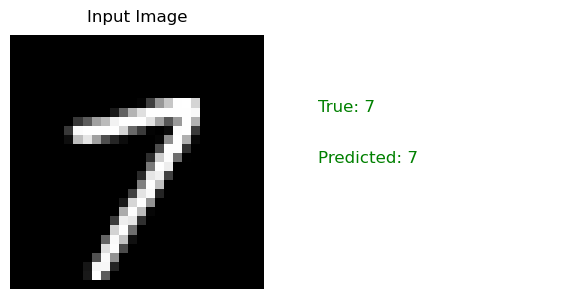

In [12]:
# Example usage with MNIST
class_names = [str(i) for i in range(10)]  # ['0', '1', ..., '9']
test_loader_shuffled = DataLoader(test_data, batch_size=batch_size, shuffle=True)
x_test, y_test = next(iter(test_loader_shuffled))
random_idx = random.randint(0, batch_size-1)
pred = predict(x_test[random_idx])

plot_prediction(x_test[random_idx],
               y_test[random_idx].item(),
               pred.item(),
               class_names)